In [1]:
import numpy as np
import random
import time
import copy
import torch
import gymnasium as gym
import matplotlib.pyplot as plt
import pandas as pd

from evogym.envs import *
from evogym import EvoViewer, get_full_connectivity, sample_robot, is_connected

from neural_controller import NeuralController, set_weights

SEED = [42, 43, 44, 45, 46]


In [12]:
def run_experiment(algorithm, num_runs=5, num_generations=100, scenario='GapJumper-v0',
                   steps=500, algorithm_name=None, SEED=None):
    best_fitnesses_overall = np.zeros(num_generations)
    mean_fitnesses = np.zeros(num_generations)
    std_fitnesses = np.zeros(num_generations)

    total_execution_time = 0
    best_overall_fitness = float('-inf')
    best_overall_weights = None

    if SEED is None:
        SEED = [random.randint(0, 9999) for _ in range(num_runs)]

    for i in range(num_runs):
        seed = SEED[i]
        print(f"\nRunning {algorithm.__name__} {i + 1}/{num_runs} (Seed {seed})...")
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)

        (best_structure, best_weights, best_fitness, best_fitness_scores,
         mean_fitness_scores, exec_time, std_fitness_scores) = algorithm()

        print(f"Best fitness score of run {i + 1}: {best_fitness:.3f}")

        best_fitnesses_overall += np.array(best_fitness_scores)
        mean_fitnesses += np.array(mean_fitness_scores)
        std_fitnesses += np.array(std_fitness_scores)

        if best_fitness > best_overall_fitness:
            best_overall_fitness = best_fitness
            best_overall_weights = best_weights

        # Save individual run CSV
        df = pd.DataFrame({
            'Generation': range(num_generations),
            'Reward': best_fitness_scores,
            'Best Controller Weights': [best_weights] * num_generations,
            'Best Structure': [best_structure.tolist()] * num_generations,
            'Best Fitness': best_fitness_scores,
            'Mean Fitness': mean_fitness_scores,
            'Std Fitness': std_fitness_scores,
            'Execution Time': [exec_time] * num_generations
        })

        algo_name = algorithm_name or algorithm.__name__
        csv_name = f"{algo_name}_{scenario}_seed_{seed}.csv"
        df.to_csv(csv_name, index=False)
        print(f"Saved run {i + 1} results to {csv_name}")

        total_execution_time += exec_time

    # Compute averages
    best_fitnesses_overall /= num_runs
    mean_fitnesses /= num_runs
    std_fitnesses /= num_runs
    mean_exec_time = total_execution_time / num_runs

    print("\nFinal Results After Multiple Runs:")
    print(f"Mean execution time: {mean_exec_time:.2f} seconds")
    print(f"Best fitness found: {best_overall_fitness:.3f}")

    # Save summary CSV
    summary_df = pd.DataFrame({
        'Generation': range(num_generations),
        'Mean Best Fitness': best_fitnesses_overall,
        'Mean Fitness': mean_fitnesses,
        'Std Fitness': std_fitnesses,
        'Mean Execution Time': [mean_exec_time] * num_generations
    })

    summary_csv = f"{algo_name}_{scenario}_summary.csv"
    summary_df.to_csv(summary_csv, index=False)
    print(f"Saved summary results to {summary_csv}")

    # Plot summary
    plt.figure(figsize=(10, 5))
    plt.plot(best_fitnesses_overall, label="Mean Best Fitness", color='blue')
    plt.fill_between(range(num_generations),
                     best_fitnesses_overall - std_fitnesses,
                     best_fitnesses_overall + std_fitnesses,
                     color='blue', alpha=0.2, label='Std Dev Range')
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title(f"{algo_name}: Fitness Evolution in {scenario}")
    plt.legend()
    plt.grid()
    plt.show()

    return best_overall_weights, best_overall_fitness, best_fitnesses_overall, mean_fitnesses, mean_exec_time, std_fitnesses


In [7]:
# --- PARAMETERS ---
POP_SIZE = 40
NUM_GENERATIONS = 100
STEPS = 500
SCENARIO = 'GapJumper-v0'
ELITE_RATIO = 0.2
VOXEL_TYPES = [0, 1, 2, 3, 4]

# --- ENVIRONMENT SETUP ---
def create_env(structure):
    conn = get_full_connectivity(structure)
    return gym.make(SCENARIO, max_episode_steps=STEPS, body=structure, connections=conn)

# --- Robot utils ---
def create_random_robot():
    while True:
        robot, _ = sample_robot((5, 5))
        if is_connected(robot):
            return robot

def mutate_robot(robot, mutation_rate=0.1):
    new = copy.deepcopy(robot)
    for i in range(new.shape[0]):
        for j in range(new.shape[1]):
            if random.random() < mutation_rate:
                new[i, j] = random.choice(VOXEL_TYPES)
    return new if is_connected(new) else robot

dummy_structure = create_random_robot()
dummy_env = create_env(dummy_structure)
input_size = dummy_env.observation_space.shape[0]
output_size = dummy_env.action_space.shape[0]
dummy_env.close()

brain = NeuralController(input_size, output_size)
shapes = [p.shape for p in brain.parameters()]

# --- HELPERS ---
def vectorize(weights):
    return np.concatenate([w.flatten() for w in weights])

def devectorize(vec, shapes):
    weights, idx = [], 0
    for shape in shapes:
        size = np.prod(shape)
        weights.append(vec[idx:idx + size].reshape(shape))
        idx += size
    return weights


# --- Controller utils ---
def create_random_controller():
    return [np.random.randn(*p.shape) for p in brain.parameters()]

def mutate_controller(controller, std=0.1):
    return [w + np.random.normal(0, std, w.shape) for w in controller]

# --- Evaluation ---
def evaluate_fitness(structure, controller, view=False):
    try:
        set_weights(brain, controller)
        env = create_env(structure)
        viewer = EvoViewer(env) if view else None
        if viewer:
            viewer.track_objects('robot')

        state, _ = env.reset()
        total_reward = 0

        for _ in range(STEPS):
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            action = brain(state_tensor).detach().numpy().flatten()
            if view:
                viewer.render('screen')
            state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
            if terminated or truncated:
                break

        if viewer: viewer.close()
        env.close()
        return total_reward
    except:
        return 0.0

# --- Mutation wrapper ---
def mutate_individual(structure, controller):
    return mutate_robot(structure), mutate_controller(controller)

# --- Main Co-evolutionary Loop ---
def random_coevolution(seed=None):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)

    population = [(create_random_robot(), create_random_controller()) for _ in range(POP_SIZE)]
    best_fitness_scores, mean_fitness_scores, std_fitness_scores = [], [], []
    best_overall_fitness = float('-inf')
    best_structure = None
    best_controller = None

    start_time = time.time()

    for gen in range(NUM_GENERATIONS):
        fitnesses = [evaluate_fitness(s, c) for s, c in population]
        best_idx = np.argmax(fitnesses)

        if fitnesses[best_idx] > best_overall_fitness:
            best_overall_fitness = fitnesses[best_idx]
            best_structure, best_controller = copy.deepcopy(population[best_idx])

        best_fitness_scores.append(fitnesses[best_idx])
        mean_fitness_scores.append(np.mean(fitnesses))
        std_fitness_scores.append(np.std(fitnesses))

        elites = [population[i] for i in np.argsort(fitnesses)[-int(ELITE_RATIO * POP_SIZE):]]
        offspring = [mutate_individual(*random.choice(elites)) for _ in range(POP_SIZE - len(elites))]
        population = elites + offspring

    exec_time = time.time() - start_time

    return (
        best_controller,
        best_overall_fitness,
        best_fitness_scores,
        mean_fitness_scores,
        exec_time,
        std_fitness_scores,
        best_structure
    )


In [ ]:
# Run the experiment with random coevolution
best_w, best_f, bests, means, mean_time, stds = run_experiment(random_coevolution, num_runs=5, algorithm_name="random_coev", SEED=SEED)



Running random_coevolution 1/5 (Seed 42)...
Best fitness score of run 1: 0.000
Saved run 1 results to random_coev_GapJumper-v0_seed_42.csv

Running random_coevolution 2/5 (Seed 43)...
Best fitness score of run 2: 0.000
Saved run 2 results to random_coev_GapJumper-v0_seed_43.csv

Running random_coevolution 3/5 (Seed 44)...


In [ ]:
# Change the scenario
best_w, best_f, bests, means, mean_time, stds = run_experiment(random_coevolution, num_runs=5, algorithm_name="random_coev", SEED=SEED, scenario='CaveCrawler-v0')


Running random_coevolution 1/5 (Seed 42)...
Best fitness score of run 1: 1.006
Saved run 1 results to random_coev_CaveCrawler-v0_seed_42.csv

Running random_coevolution 2/5 (Seed 43)...
Best fitness score of run 2: 1.963
Saved run 2 results to random_coev_CaveCrawler-v0_seed_43.csv

Running random_coevolution 3/5 (Seed 44)...


## Random Pairing Co-Evolution

In [13]:
# --- PARAMETERS ---
POP_SIZE = 40
NUM_GENERATIONS = 100
STEPS = 500
SCENARIO = 'GapJumper-v0'
ELITE_RATIO = 0.2
VOXEL_TYPES = [0, 1, 2, 3, 4]

# --- ENVIRONMENT SETUP ---
def create_env(structure):
    conn = get_full_connectivity(structure)
    return gym.make(SCENARIO, max_episode_steps=STEPS, body=structure, connections=conn)

# --- Robot utils ---
def create_random_robot():
    while True:
        robot, _ = sample_robot((5, 5))
        if is_connected(robot):
            return robot

def mutate_robot(robot, mutation_rate=0.1):
    new = copy.deepcopy(robot)
    for i in range(new.shape[0]):
        for j in range(new.shape[1]):
            if random.random() < mutation_rate:
                new[i, j] = random.choice(VOXEL_TYPES)
    return new if is_connected(new) else robot

dummy_structure = create_random_robot()
dummy_env = create_env(dummy_structure)
input_size = dummy_env.observation_space.shape[0]
output_size = dummy_env.action_space.shape[0]
dummy_env.close()

brain = NeuralController(input_size, output_size)
shapes = [p.shape for p in brain.parameters()]

# --- HELPERS ---
def vectorize(weights):
    return np.concatenate([w.flatten() for w in weights])

def devectorize(vec, shapes):
    weights, idx = [], 0
    for shape in shapes:
        size = np.prod(shape)
        weights.append(vec[idx:idx + size].reshape(shape))
        idx += size
    return weights


# --- Controller utils ---
def create_random_controller():
    return [np.random.randn(*p.shape) for p in brain.parameters()]

def mutate_controller(controller, std=0.1):
    return [w + np.random.normal(0, std, w.shape) for w in controller]

# --- Crossover ---
def crossover(parent1, parent2):
    child = copy.deepcopy(parent1)
    for i in range(len(parent1)):
        if random.random() < 0.5: # Crossover point
            child[i] = parent2[i]
    return child if is_connected(child) else parent1 # Fallback to parent1

# --- Evaluation ---
def evaluate_fitness(structure, controller, view=False):
    try:
        set_weights(brain, controller)
        env = create_env(structure)
        viewer = EvoViewer(env) if view else None
        if viewer:
            viewer.track_objects('robot')

        state, _ = env.reset()
        total_reward = 0

        for _ in range(STEPS):
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            action = brain(state_tensor).detach().numpy().flatten()
            if view:
                viewer.render('screen')
            state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
            if terminated or truncated:
                break

        if viewer: viewer.close()
        env.close()
        return total_reward
    except:
        return 0.0


## RANDOM PAIRING COEVOLUTION
def random_pairing_coevolution():
    # Initialize separate populations
    structures = [create_random_robot() for _ in range(POP_SIZE)]
    controllers = [create_random_controller() for _ in range(POP_SIZE)]

    best_fitness_scores = []
    mean_fitness_scores = []
    std_fitness_scores = []

    best_overall_fitness = float('-inf')
    best_structure = None
    best_controller = None

    start_time = time.time()

    for gen in range(NUM_GENERATIONS):
        pairings = []
        fitnesses = []

        # --- Random pairing: each structure is paired with a random controller
        for i in range(POP_SIZE):
            s = structures[i]
            c = random.choice(controllers)
            fitness = evaluate_fitness(s, c)
            pairings.append((s, c, fitness))
            fitnesses.append(fitness)

        # --- Stats
        best_idx = np.argmax(fitnesses)
        best_s, best_c, best_fit = pairings[best_idx]
        best_fitness_scores.append(best_fit)
        mean_fitness_scores.append(np.mean(fitnesses))
        std_fitness_scores.append(np.std(fitnesses))

        if best_fit > best_overall_fitness:
            best_overall_fitness = float(best_fit)
            best_structure = copy.deepcopy(best_s)
            best_controller = copy.deepcopy(best_c)

        # --- Elitism
        num_elites = int(ELITE_RATIO * POP_SIZE)
        elite_pairings = sorted(pairings, key=lambda x: x[2], reverse=True)[:num_elites]
        elite_structures = [copy.deepcopy(s) for s, _, _ in elite_pairings]
        elite_controllers = [vectorize(c) for _, c, _ in elite_pairings]

        # --- Evolve structures: selection + crossover + mutation
        tournament_size = 3
        selected_structures = []
        for _ in range(POP_SIZE - num_elites):
            contenders = random.sample(pairings, tournament_size)
            winner = max(contenders, key=lambda x: x[2])[0]
            selected_structures.append(winner)

        offspring_structures = []
        for _ in range(POP_SIZE - num_elites):
            p1 = random.choice(selected_structures)
            p2 = random.choice(selected_structures)
            child = crossover(p1, p2)
            child = mutate_robot(child)
            offspring_structures.append(child)

        # --- Evolve controllers using DE
        offspring_controllers = []
        for _ in range(POP_SIZE - num_elites):
            a, b, c = random.sample(elite_controllers, 3)
            F, CR = 0.8, 0.9
            mutant = a + F * (b - c)
            trial = np.copy(mutant)
            for i in range(len(trial)):
                if random.random() > CR:
                    trial[i] = a[i]
            weights = devectorize(trial, shapes)
            offspring_controllers.append(weights)

        # --- Form new populations
        structures = elite_structures + offspring_structures
        controllers = [devectorize(w, shapes) for w in elite_controllers] + offspring_controllers

    exec_time = time.time() - start_time

    return (
        best_structure,
        best_controller,
        best_overall_fitness,
        best_fitness_scores,
        mean_fitness_scores,
        exec_time,
        std_fitness_scores
    )




Running random_pairing_coevolution 1/5 (Seed 42)...
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 1: 1.899
Saved run 1 results to random_pairing_GapJumper-v0_seed_42.csv

Running random_pairing_coevolution 2/5 (Seed 43)...
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 2: 1.834
Saved run 2 results to random_pairing_GapJumper-v0_seed_43.csv

Running random_pairing_coevolution 3/5 (Seed 44)...
Best fitness score of run 3: 1.975
Saved run 3 results to random_pairing_GapJumper-v0_seed_44.csv

Running random_pairing_coevolution 4/5 (Seed 45)...
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 4: 1.627
Saved run 4 results to random_pairing_GapJumper-v0_seed_45.csv

Running random_pairing_coevolution 5/5 (Seed 46)...
Best fitness score of run 5: 0.592
Saved run 5 results to random_pairing_GapJumper-v0_seed_46.csv

Final Results After Multiple Runs:
Mean execution time: 1732.33 seconds
Best fitness found: 1.975
Saved summary results to random_pairing_G

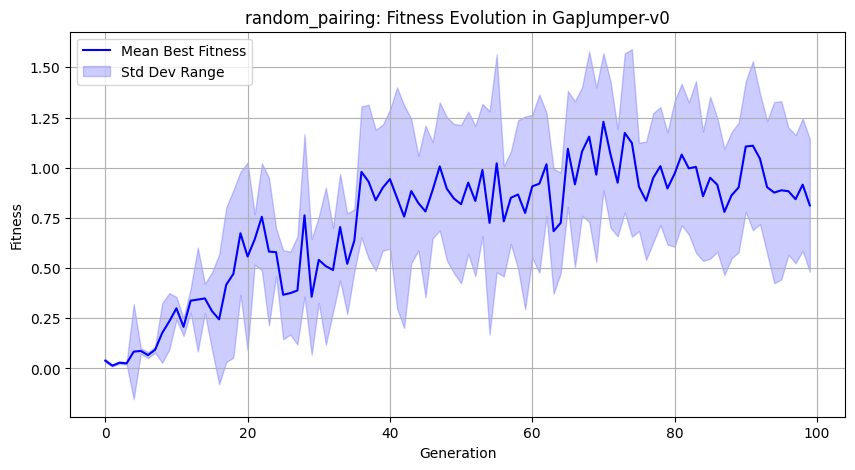

Best fitness: 1.9746573968672476


In [14]:
# Run the experiment with random pairing coevolution
best_w, best_f, bests, means, mean_time, stds = run_experiment(random_pairing_coevolution, num_runs=5, algorithm_name="random_pairing", SEED=SEED)

#print("Best weights:", best_w)
print("Best fitness:", best_f)


Running random_pairing_coevolution 1/5 (Seed 42)...
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 1: 1.899
Saved run 1 results to random_pairing_CaveCrawler-v0_seed_42.csv

Running random_pairing_coevolution 2/5 (Seed 43)...
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 2: 1.834
Saved run 2 results to random_pairing_CaveCrawler-v0_seed_43.csv

Running random_pairing_coevolution 3/5 (Seed 44)...
Best fitness score of run 3: 1.975
Saved run 3 results to random_pairing_CaveCrawler-v0_seed_44.csv

Running random_pairing_coevolution 4/5 (Seed 45)...
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 4: 1.627
Saved run 4 results to random_pairing_CaveCrawler-v0_seed_45.csv

Running random_pairing_coevolution 5/5 (Seed 46)...
Best fitness score of run 5: 0.592
Saved run 5 results to random_pairing_CaveCrawler-v0_seed_46.csv

Final Results After Multiple Runs:
Mean execution time: 1659.65 seconds
Best fitness found: 1.975
Saved summary results to random

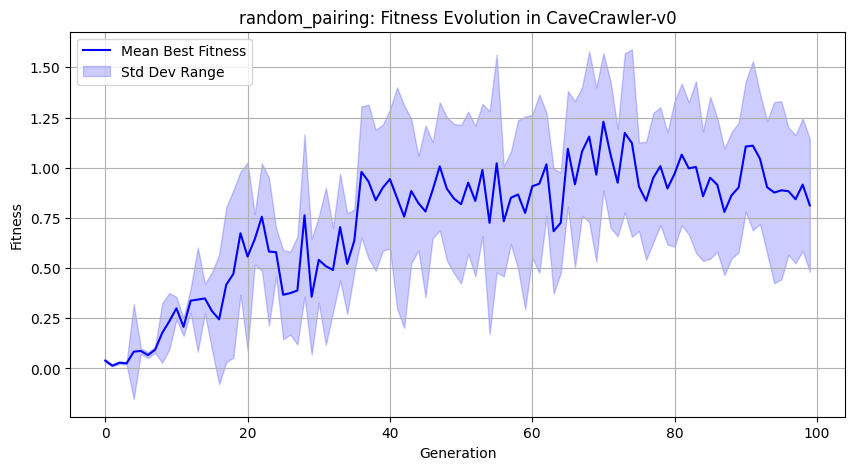

Best fitness: 1.9746573968672476


In [15]:
# Change the scenario
best_w, best_f, bests, means, mean_time, stds = run_experiment(random_pairing_coevolution, num_runs=5, algorithm_name="random_pairing", SEED=SEED, scenario='CaveCrawler-v0')

print("Best fitness:", best_f)

## Best-Of-Opposite Pairing Coevolution

In [16]:
def best_of_opposite_coevolution():
    # Separate structure and controller populations
    structures = [create_random_robot() for _ in range(POP_SIZE)]
    controllers = [create_random_controller() for _ in range(POP_SIZE)]

    best_fitness_scores = []
    mean_fitness_scores = []
    std_fitness_scores = []

    best_overall_fitness = float('-inf')
    best_structure = None
    best_controller = None

    start_time = time.time()

    for gen in range(NUM_GENERATIONS):
        # --- Identify best individuals in each population (evaluate against random partners)
        controller_fitnesses = []
        for c in controllers:
            s = random.choice(structures)
            fitness = evaluate_fitness(s, c)
            controller_fitnesses.append(fitness)
        best_controller = controllers[np.argmax(controller_fitnesses)]

        structure_fitnesses = []
        for s in structures:
            c = random.choice(controllers)
            fitness = evaluate_fitness(s, c)
            structure_fitnesses.append(fitness)
        best_structure = structures[np.argmax(structure_fitnesses)]

        # --- Now evaluate everyone against the *best of opposite population*
        pairings = []
        fitnesses = []

        for s in structures:
            fitness = evaluate_fitness(s, best_controller)
            pairings.append((s, best_controller, fitness))
            fitnesses.append(fitness)

        for c in controllers:
            fitness = evaluate_fitness(best_structure, c)
            pairings.append((best_structure, c, fitness))
            fitnesses.append(fitness)

        # --- Track statistics
        best_idx = np.argmax(fitnesses)
        best_s, best_c, best_fit = pairings[best_idx]
        best_fitness_scores.append(best_fit)
        mean_fitness_scores.append(np.mean(fitnesses))
        std_fitness_scores.append(np.std(fitnesses))

        if best_fit > best_overall_fitness:
            best_overall_fitness = float(best_fit)
            best_structure = copy.deepcopy(best_s)
            best_controller = copy.deepcopy(best_c)

        # --- Elitism
        num_elites = int(ELITE_RATIO * POP_SIZE)
        elite_pairings = sorted(pairings, key=lambda x: x[2], reverse=True)[:num_elites]
        elite_structures = [copy.deepcopy(s) for s, _, _ in elite_pairings]
        elite_controllers = [vectorize(c) for _, c, _ in elite_pairings]

        # --- Evolve structures
        tournament_size = 3
        selected_structures = []
        for _ in range(POP_SIZE - num_elites):
            contenders = random.sample(elite_structures, tournament_size)
            selected_structures.append(max(contenders, key=lambda s: evaluate_fitness(s, best_controller)))

        offspring_structures = []
        for _ in range(POP_SIZE - num_elites):
            p1 = random.choice(selected_structures)
            p2 = random.choice(selected_structures)
            child = crossover(p1, p2)
            child = mutate_robot(child)
            offspring_structures.append(child)

        # --- Evolve controllers with DE
        offspring_controllers = []
        for _ in range(POP_SIZE - num_elites):
            a, b, c = random.sample(elite_controllers, 3)
            F, CR = 0.8, 0.9
            mutant = a + F * (b - c)
            trial = np.copy(mutant)
            for i in range(len(trial)):
                if random.random() > CR:
                    trial[i] = a[i]
            weights = devectorize(trial, shapes)
            offspring_controllers.append(weights)

        # --- Form next populations
        structures = elite_structures + offspring_structures
        controllers = [devectorize(w, shapes) for w in elite_controllers] + offspring_controllers

    exec_time = time.time() - start_time

    return (
        best_structure,
        best_controller,
        best_overall_fitness,
        best_fitness_scores,
        mean_fitness_scores,
        exec_time,
        std_fitness_scores
    )


In [ ]:
# Run the experiment with best of opposite coevolution
best_w, best_f, bests, means, mean_time, stds = run_experiment(best_of_opposite_coevolution, num_runs=5, algorithm_name="best_of_opposite", SEED=SEED)
print("Best fitness:", best_f)


Running best_of_opposite_coevolution 1/5 (Seed 42)...


In [ ]:
# Change the scenario
best_w, best_f, bests, means, mean_time, stds = run_experiment(best_of_opposite_coevolution, num_runs=5, algorithm_name="best_of_opposite", SEED=SEED, scenario='CaveCrawler-v0')
print("Best fitness:", best_f)